In [1]:
%load_ext autoreload
%autoreload 2
from train_model import *
from importlib import reload
from train_model import *
from copy import deepcopy 
import matplotlib.pyplot as plt
import seaborn as sns
config_f = 'config_live.yml'

with open(config_f, 'r') as f: kwargs = yaml.load(f, Loader=yaml.FullLoader)
kwargs = utils_functions.exec_kwargs(kwargs)
world_size, kwargs = utils_functions.run_setup(**kwargs)




***************** MAIN START 04:37PM-February/24/2025******************


Resuming training after saved epoch: 217
INPUT TO <ENC>
x:torch.Size([4, 255, 256, 2])
mean:torch.Size([4, 247, 1024])
logvar:torch.Size([4, 247, 1024])
latent:torch.Size([4, 247, 1024])
class_probs:torch.Size([4, 40])

Adversarial Loss: 0.9999833106994629



INPUT TO <VAE - Decoder Mode> 
z:torch.Size([4, 247, 1024])
hash_pat_embedding:torch.Size([4, 1024])

decoder_out:torch.Size([4, 247, 256, 2])



# Overview
This notebook is dedicated to exploring the tornadoes model as implemented on Feb. 22nd 2025. This notebook starts from the point of preprocessed data. The dataloader class uses "little pickles" to prepare batches for training each epoch. Little pickles refer to the granular chunks of cleaned and normalized SEEG data produced by the scripts within preprocess. A future notebook will explore the preproccessing methodology. For now, let us examine the lil pickes. 

An overarching goal here is to be diligent in our bookkeeping. Keeping tensor dimensions straight may be a bit difficult. However in this notebook, we will always assess our understanding by converting back to a time series representation. 


## Data Loader and Little Pickle visualization

In [2]:
# Generating dataset
gpu_id = 0
pat_dir = kwargs['pat_dir']
pat_files = glob.glob(pat_dir +"/*/*.pkl")
val_pats_dirs = all_pats_dirs = [pat_dir]
ex_file = pat_files[0]

file_path = os.path.join(val_pats_dirs[0],'scaled_data_epochs',ex_file)

file = open(file_path,'rb')
data = pickle.load(file) 
file.close()

A raw pickle file: this is the result of histogram renormalization. These files are grouped into datasets and dynamically loaded by DataLoader classes. Let's next make a data loader class.

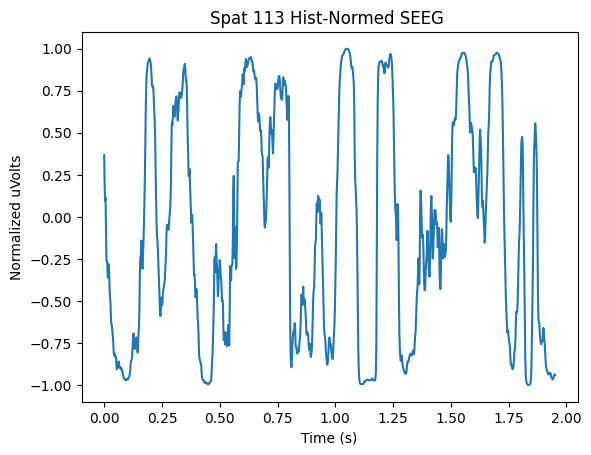

In [3]:
%matplotlib inline
T=1000
sns.lineplot(x=np.arange(T)/512, y= data[0,0:T])
plt.xlabel("Time (s)")
plt.ylabel("Normalized uVolts")
plt.title("Spat 113 Hist-Normed SEEG ")
plt.show()


In [4]:
# reminding myself about how pop() works
tst = {'a':1,'b':2}
print(tst.pop('a'))
tst

1


{'b': 2}

In [5]:
pat_dir

'/home/ghassanmakhoul/Documents/results/Bipole_datasets/By_Channel_Scale/HistEqualScale/data_normalized_to_first_24_hours/wholeband/DurStr_1024s896s_epoched_datasets/Spat113'

In [6]:
[dir.strip().split("/") for dir in val_pats_dirs]

[['',
  'home',
  'ghassanmakhoul',
  'Documents',
  'results',
  'Bipole_datasets',
  'By_Channel_Scale',
  'HistEqualScale',
  'data_normalized_to_first_24_hours',
  'wholeband',
  'DurStr_1024s896s_epoched_datasets',
  'Spat113']]

In [7]:
val_pats_dirs

['/home/ghassanmakhoul/Documents/results/Bipole_datasets/By_Channel_Scale/HistEqualScale/data_normalized_to_first_24_hours/wholeband/DurStr_1024s896s_epoched_datasets/Spat113']

In [8]:


# 0. For posterity's sake let's make a deepcopy of this config dictionary
# That way we can conform to the call strings of each function without losing the whole config
dset_kwargs = deepcopy(kwargs)
# 1. Let's define our dataset. DataLoader needs Dataset. 
kwargs['train_val_pat_perc']
pat_dir = dset_kwargs['pat_dir']
intrapatient_dataset_style =  dset_kwargs.pop('intrapatient_dataset_style')
val_finetune_hour_dataset_range = dset_kwargs.pop('val_finetune_hour_dataset_range')
val_num_rand_hashes = dset_kwargs.pop('val_num_rand_hashes')
valfinetune_forward_passes = dset_kwargs.pop('valfinetune_forward_passes')
dataset_pic_dir = '~/Documents/Tornadoes_v1/viz'

val_pats_dirs = all_pats_dirs = [pat_dir]
val_pats_list = [dir.split("/")[-1] for dir in val_pats_dirs]

valfinetune_dataset = SEEG_Tornado_Dataset(
    gpu_id=gpu_id, 
    pat_list = val_pats_list,
    pat_dirs=val_pats_dirs,
    intrapatient_dataset_style=intrapatient_dataset_style, 
    hour_dataset_range=val_finetune_hour_dataset_range,
    num_rand_hashes=val_num_rand_hashes,
    num_forward_passes=valfinetune_forward_passes,
    dataset_pic_dir=dataset_pic_dir,
    **dset_kwargs)


2025-02-24 16:38:04.053 | INFO     | data:__init__:86 - Loading 0th patient, Spat113
2025-02-24 16:38:04.053 | INFO     | data:__init__:89 - Loading from /home/ghassanmakhoul/Documents/results/Bipole_datasets/By_Channel_Scale/HistEqualScale/data_normalized_to_first_24_hours/wholeband/DurStr_1024s896s_epoched_datasets/Spat113 for the following range: [2, 50]
2025-02-24 16:38:04.055 | INFO     | utilities.utils_functions:get_desired_fnames:2822 - Found 410, from directory: /home/ghassanmakhoul/Documents/results/Bipole_datasets/By_Channel_Scale/HistEqualScale/data_normalized_to_first_24_hours/wholeband/DurStr_1024s896s_epoched_datasets/Spat113


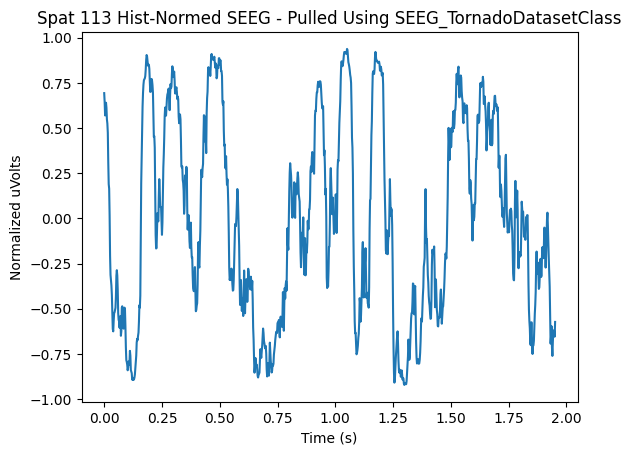

Data tensor shape from pkl: torch.Size([129, 524288])


In [21]:
# since the SEEG_Tornado_Dataset class implements the __getitem__ method, we should be able to index into this like a list
data_tensor, f_name = valfinetune_dataset[0]
data_tensor.shape
# Here is a plot of this dataset:
T=1000
sns.lineplot(x=np.arange(T)/512, y= data_tensor[0,0:T])
plt.xlabel("Time (s)")
plt.ylabel("Normalized uVolts")
plt.title("Spat 113 Hist-Normed SEEG - Pulled Using SEEG_TornadoDatasetClass")
plt.show()
print(f"Data tensor shape from pkl: {data_tensor.shape}")

Now let's trace the forward pass of the model and track all data transformations. To do this we will need to load the trainer object. Trainer objects coordinate data passage into the model, running an epoch and training the model via stepping the optimizatino and percolating those gradients backwargs. 

In the following steps we will take over the job of the trainer class.

First the trainer class uses a dataloader. DataLoaders handle batching, shuffling, and other management of datasets. Dataloader needs an SEEG_dataset object.


In [11]:
trainer_kwargs = deepcopy(kwargs)
#NOTE: This data directory discrepancy is a major bummer. TODO: sort out at what level this pat_dir is expected to operate.
trainer_kwargs['pat_dir'] = '/home/ghassanmakhoul/Documents/results/Bipole_datasets/By_Channel_Scale/HistEqualScale/data_normalized_to_first_24_hours/wholeband/DurStr_1024s896s_epoched_datasets'


In [12]:
trainer_kwargs['max_batch_size'] * trainer_kwargs['inference_batch_mult']

4

In [13]:
# Loading data, model weights, optimizer, and classifier
train_dataset, valfinetune_dataset, valunseen_dataset, vae, opt_vae, opt_cls = load_train_objs(gpu_id=gpu_id, **trainer_kwargs) 

#getting data loader running on valfinetune_dataset
dataloader = utils_functions.prepare_dataloader(valfinetune_dataset, batch_size=trainer_kwargs['max_batch_size'] * trainer_kwargs['inference_batch_mult'], num_workers=0, distributed=False)


2025-02-24 16:38:20.227 | INFO     | data:__init__:86 - Loading 0th patient, Spat113
2025-02-24 16:38:20.227 | INFO     | data:__init__:89 - Loading from /home/ghassanmakhoul/Documents/results/Bipole_datasets/By_Channel_Scale/HistEqualScale/data_normalized_to_first_24_hours/wholeband/DurStr_1024s896s_epoched_datasets/Spat113 for the following range: [2, 50]
2025-02-24 16:38:20.229 | INFO     | utilities.utils_functions:get_desired_fnames:2822 - Found 410, from directory: /home/ghassanmakhoul/Documents/results/Bipole_datasets/By_Channel_Scale/HistEqualScale/data_normalized_to_first_24_hours/wholeband/DurStr_1024s896s_epoched_datasets/Spat113


[GPU0] Generating VALIDATION FINETUNE dataset


2025-02-24 16:38:20.834 | INFO     | data:__init__:86 - Loading 0th patient, Spat113
2025-02-24 16:38:20.834 | INFO     | data:__init__:89 - Loading from /home/ghassanmakhoul/Documents/results/Bipole_datasets/By_Channel_Scale/HistEqualScale/data_normalized_to_first_24_hours/wholeband/DurStr_1024s896s_epoched_datasets/Spat113 for the following range: [50, -1]
2025-02-24 16:38:20.836 | INFO     | utilities.utils_functions:get_desired_fnames:2822 - Found 410, from directory: /home/ghassanmakhoul/Documents/results/Bipole_datasets/By_Channel_Scale/HistEqualScale/data_normalized_to_first_24_hours/wholeband/DurStr_1024s896s_epoched_datasets/Spat113


[GPU0] Generating VALIDATION UNSEEN dataset


2025-02-24 16:38:21.514 | WARNING  | data:__init__:61 - No patient directories found! for []


[GPU0] Generating TRAIN dataset


In [14]:
valfinetune_dataset.pat_fnames

[['/home/ghassanmakhoul/Documents/results/Bipole_datasets/By_Channel_Scale/HistEqualScale/data_normalized_to_first_24_hours/wholeband/DurStr_1024s896s_epoched_datasets/Spat113/scaled_data_epochs/Spat113_01302025_01254006_to_01302025_01424406_bipole_scaled_filtered_data.pkl',
  '/home/ghassanmakhoul/Documents/results/Bipole_datasets/By_Channel_Scale/HistEqualScale/data_normalized_to_first_24_hours/wholeband/DurStr_1024s896s_epoched_datasets/Spat113/scaled_data_epochs/Spat113_01302025_01403606_to_01302025_01574006_bipole_scaled_filtered_data.pkl',
  '/home/ghassanmakhoul/Documents/results/Bipole_datasets/By_Channel_Scale/HistEqualScale/data_normalized_to_first_24_hours/wholeband/DurStr_1024s896s_epoched_datasets/Spat113/scaled_data_epochs/Spat113_01302025_01553206_to_01302025_02123606_bipole_scaled_filtered_data.pkl',
  '/home/ghassanmakhoul/Documents/results/Bipole_datasets/By_Channel_Scale/HistEqualScale/data_normalized_to_first_24_hours/wholeband/DurStr_1024s896s_epoched_datasets/Spat

In [15]:
batch_tensor, file_names = next(iter(dataloader))
# kind of a hacky way to get a batch 
batch_tensor.shape

torch.Size([4, 129, 524288])

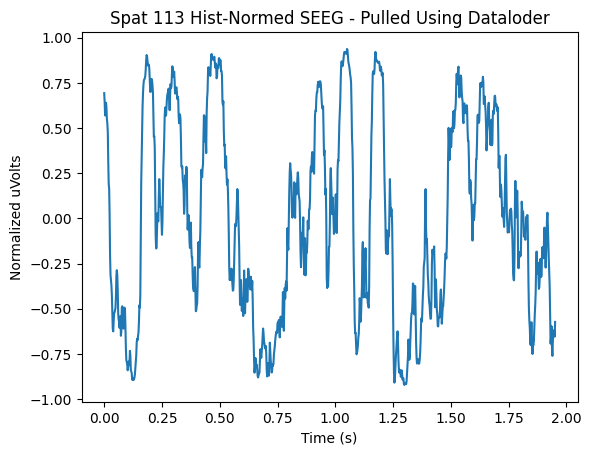

Data tensor shape from pkl: torch.Size([4, 129, 524288])


In [19]:
# Let's pull out the first time series from the batched tensor so we can track how it is transformed

# Here is a plot of this dataset:
T=1000
sns.lineplot(x=np.arange(T)/512, y= batch_tensor[0,0,0:T])
plt.xlabel("Time (s)")
plt.ylabel("Normalized uVolts")
plt.title("Spat 113 Hist-Normed SEEG - Pulled Using Dataloder")
plt.show()
print(f"Data tensor shape from pkl: {batch_tensor.shape}")

In [17]:
# let's build up the data shape for a forward pass
#NOTE: As is the dataloader generates a file with many windows
# and then the model "knows" to iterate over all the windows
# would it not be more modular to implement a version of the model that has 
# no idea what the data should look like. Specifically, what if data loader also 
# was in charge of pulling out window-ed data? We could then shuffles in and out of 
# patient data within windows. May encourage better mixing 
transformer_seq_length =  trainer_kwargs['transformer_seq_length']
autoencode_samples = trainer_kwargs['autoencode_samples']
num_samples_in_forward = transformer_seq_length * autoencode_samples
num_windows_in_file = batch_tensor.shape[2] / num_samples_in_forward
print(f"Number of samples in the forward pass: {num_samples_in_forward} leads to \
{num_windows_in_file} windows per file")


## ready to set up the true input shape:
batch_num = batch_tensor.shape[0]
n_ch = batch_tensor.shape[1]

x = torch.zeros(batch_num, transformer_seq_length, n_ch, autoencode_samples)
x.shape

Number of samples in the forward pass: 512 leads to 1024.0 windows per file


torch.Size([4, 256, 129, 2])

In [22]:
num_samples_in_forward

512

In [70]:
autoencode_samples

2

In [81]:
n_ch_pad = 256
for w in range(int(num_windows_in_file)):
    x = torch.zeros(batch_num, transformer_seq_length, n_ch_pad, autoencode_samples).to(0)
    start_idx = w * num_samples_in_forward
    for embedding_idx in range(0, transformer_seq_length): # 256 iterations
        # Pull out data for this window - NOTE: no hashing
        
        end_idx = start_idx + autoencode_samples * embedding_idx + autoencode_samples 
        print(f"Start {end_idx - autoencode_samples} end {end_idx}")
        x[:, embedding_idx, 0:n_ch, :] = batch_tensor[:, :, end_idx-autoencode_samples : end_idx]

    break


Start 0 end 2
Start 2 end 4
Start 4 end 6
Start 6 end 8
Start 8 end 10
Start 10 end 12
Start 12 end 14
Start 14 end 16
Start 16 end 18
Start 18 end 20
Start 20 end 22
Start 22 end 24
Start 24 end 26
Start 26 end 28
Start 28 end 30
Start 30 end 32
Start 32 end 34
Start 34 end 36
Start 36 end 38
Start 38 end 40
Start 40 end 42
Start 42 end 44
Start 44 end 46
Start 46 end 48
Start 48 end 50
Start 50 end 52
Start 52 end 54
Start 54 end 56
Start 56 end 58
Start 58 end 60
Start 60 end 62
Start 62 end 64
Start 64 end 66
Start 66 end 68
Start 68 end 70
Start 70 end 72
Start 72 end 74
Start 74 end 76
Start 76 end 78
Start 78 end 80
Start 80 end 82
Start 82 end 84
Start 84 end 86
Start 86 end 88
Start 88 end 90
Start 90 end 92
Start 92 end 94
Start 94 end 96
Start 96 end 98
Start 98 end 100
Start 100 end 102
Start 102 end 104
Start 104 end 106
Start 106 end 108
Start 108 end 110
Start 110 end 112
Start 112 end 114
Start 114 end 116
Start 116 end 118
Start 118 end 120
Start 120 end 122
Start 122 

In [76]:
batch_tensor[:, :, end_idx-autoencode_samples : end_idx].shape

torch.Size([4, 129, 2])

In [43]:
token

tensor([0.6934, 0.6450])

In [50]:
ch_1[0,end_idx-2:end_idx] 

array([0., 0.])

In [53]:
data_tensor.shape

torch.Size([129, 524288])

In [61]:
x.shape

torch.Size([4, 256, 129, 2])

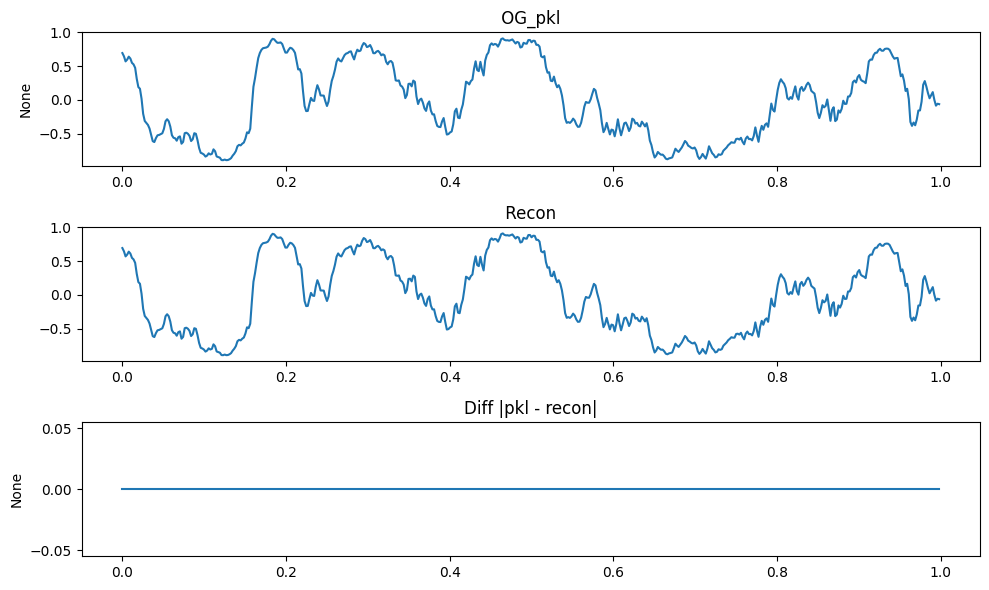

Data tensor shape from forward: torch.Size([129, 524288])


In [77]:

# Plot dset as it is batched
T=2*x.shape[1]
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 6))  # 2x2 grid

# Flatten the axes array for easy iteration
axes = axes.flatten()
end = 2
ch_1 = np.zeros((1,2*x.shape[1]))
for i in range(x.shape[1]): #256, number of tokens
    token = x[0,i,0,:] # from first batch, grab the ith token, and the first channel from that token, save both samples 
    ch_1[0, end-2:end] = token
    end += 2

y_pkl = data_tensor[0,0:T]
# Loop through each subplot
for i, ax in enumerate(axes):
    if i == 0: 
       
        sns.lineplot(x=np.arange(T)/512, y= y_pkl, ax=ax)
        ax.set_title(f' OG_pkl ')
    elif i == 1:
        y = ch_1[0,:]
        sns.lineplot(x=np.arange(T)/512, y= y, ax=ax)
        ax.set_title(f' Recon ')
    else:
        diff = y_pkl - ch_1[0,:]
        sns.lineplot(x=np.arange(T)/512, y= np.abs(diff), ax=ax)
        ax.set_title(f'Diff |pkl - recon|')

plt.tight_layout()
plt.show()
print(f"Data tensor shape from forward: {data_tensor.shape}")

## Querying the model

In [ ]:
# easy high level query:

mean, logvar, latent, class_probs_mean_of_means =vae(x[:, :-1, :, :], reverse=False)
# the model burns through the first 8 tokens to produce embedding predictions. 
# These are token predictions, where the 

mean.shape


torch.Size([4, 247, 1024])

## Dissecting the model layer by layer 
The forward call to the model involves passing x into the following layers:
Encoder_TimeSeries_Cross_Attn -> Transformer -> Linear -> Normalization Layer -> FC -> mu, std.

Let's run this model step by step.

### Layer 1: Encoder_TimeSeries_Cross_Attn
The Encoder_TimeSeries Cross Attn is made up of the following layers:
2 Implementations of TimeSeriesCrossAttn
*High Dim Cross Attn* -> Low Dim crAttn
Each Time SeriesCrossAttn Layer has the following:
- MultiHead Attention( embed dim, num_heads, dropout)
- RMS Norm(embed_dim - 1024)
- dropout layer
- fully connected layers w activation -> Linear -> SiLU (activation) - Linear 
- Norm Round 2
- Dropout round 2

Within Class data flows High_dim_attn[TimeSeriesCrossAttn] -> high_to_low_dim[sequential]-> low_dim_Attn[TimeSeriesCrossAttn]

The high_to_low_dim architecture reads as follows: Linear -> SiLU -> Linear -> Silu -> Linear -> Silu
- starts at ch x ch ends  in ch x embed_dims

Low Dim Attn_layers allows low dim embeddings to attend to each other before FC to Mu

### Layer 2: Transformer
If the last layer was compression, then this one was meant for further attending to each other. 
- autoencode_samples
    - Transformer implements N_layers (16) of transformer blocks
        - TransformerBlock implements: 
            - ATTN (*base*)
                -  q,k,v,o = nn.Linear
                - Forward: softmax((xq @ keys )/ sqrt(head_dim)) @ values - attn_layer
            - FeedForward (*base*)
                - layers: w1, w2, w3 = nn.Linear(all hidden), activation_fn = silu | tanh
                - Forward:activation_fn(w2(silu(w1)) * we)
            - ATTN_NORM = RMS_NORM
            - RMS NORM = FFN_NORMxs
        TransformerBlock Forward: Attn(ATTN_NORM) + FeedForward(FFN_NORM)
    - Forward for transforme:r implements: 16 TransformerBLock layers -> 1 RMSNorm layer

### Layer 3: Core Encoder 
This layer just takes care of some of the book-keeping and plug-ins to the VAE latent space
1. Linear -> RMSNORM


### Layer 4 Encoder Variational Layers (Not shared between enc/dec)
- mu = nn.linear
- logvar - nn.Linear

### Layer 5: Decoder MLP Layer
Instead of flipping all the attention mechanisms on their head, the decoder layer implements a series of fully connected layers (multi layer perceptrons) to sample latent dim and generate reconstructions. First the decoder implements a series of fc layers passed into SiLU and RMSNorm, then passes these into a linear and Tanh Layer

Forward:
    - h_na <- non_autoregressive_fc: Linear(SiLU(RMSNorm(z)))^5 
        - each application progressively brings up the size of the samples to higher dimensions
    - x_na <- non_autoregressive_output(h_na)


## Generating a low dimensional representation of brain state: 

### The classic PacMAP

### PHATE